In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Il nostro codice
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pickle as pk
from torchvision.datasets import ImageFolder
import json
import shutil
import torch
from torchvision import transforms
from PIL import Image

if not os.path.exists('/content/assignment_1/'):
  !unzip -P dluniud2022 /content/drive/MyDrive/dataset.zip 

#create folder of class and insert img
path_train_img = "/content/assignment_1/train/images/"
path_train_class = '/content/assignment_1/train/class/'
path_test_img = "/content/assignment_1/test/images/"
path_test_class = '/content/assignment_1/test/class/'


In [3]:
dir_list = os.listdir(path_train_img)
if not os.path.exists(path_train_class):
  os.mkdir(path_train_class)

# da leggere tutti i nomi di ogni item
for name in dir_list:
  stringa = str(name[0:6]) + ".json"
  with open('/content/assignment_1/train/annotations/' + stringa, 'r') as f:
    data = json.load(f)
    dirName = path_train_class + data['item1']['category_name']
    if not os.path.exists(dirName):
      os.mkdir(dirName)
    if not os.path.exists(dirName + name):
      shutil.copy(path_train_img + name, dirName)

In [4]:
#create Tensor
dataset = ImageFolder(path_train_class, transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

#load tensor in train
trainloader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [5]:
dir_list = os.listdir(path_test_img)
if not os.path.exists(path_test_class):
  os.mkdir(path_test_class)

# da leggere tutti i nomi di ogni item
for name in dir_list:
  stringa = str(name[0:6]) + ".json"
  with open('/content/assignment_1/test/annotations/' + stringa, 'r') as f:
    data = json.load(f)
    dirName = path_test_class + data['item1']['category_name']
    if not os.path.exists(dirName):
      os.mkdir(dirName)
    if not os.path.exists(dirName + name):
      shutil.copy(path_test_img + name, dirName)

In [6]:
#create Tensor
dataset2 = ImageFolder(path_test_class, transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

#load tensor in train
testloader = torch.utils.data.DataLoader(dataset2, batch_size=4,
                                          shuffle=True, num_workers=2)

In [ ]:

# show some img of training   
classes = os.listdir(path_train_class)
classes.sort()

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)
for img, label in zip(images, labels):
    img_unnorm = img/2 + 0.5
    img_transp = np.transpose(img_unnorm, (1,2,0))

    fig = plt.figure(figsize=(2,2))
    plt.imshow(img_transp)
    plt.title(classes[label.item()], fontweight="bold")

    plt.show()    #non so se effettivamente funziona


In [8]:
#disegnare il bounding

from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from PIL import Image
from matplotlib import image as mpimg

img_dir = path_train_class + 'vest/' + '000556.jpg'
img = read_image(img_dir)

# da leggere tutti i bounding di ogni item
stringa = str(img_dir[len(img_dir)-10:len(img_dir)-4]) + ".json"
with open('/content/assignment_1/train/annotations/' + stringa, 'r') as f:
  data = json.load(f)
  bbox = data['item1']['bounding_box']

bbox = torch.tensor(bbox, dtype=torch.int)
print(bbox)
print(bbox.size())
bbox = bbox.unsqueeze(0)
print(bbox.size())

# draw bounding box on the input image
img=draw_bounding_boxes(img, bbox, width=3, colors=(255,255,0))

# transform it to PIL image and display
img = torchvision.transforms.ToPILImage()(img)
img.save('/content/assignment_1/train/myphoto.jpg', 'JPEG')
img.show()

tensor([ 63, 220, 392, 512], dtype=torch.int32)
torch.Size([4])
torch.Size([1, 4])


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # TODO
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # First linear layer
        self.fc1 = nn.Linear(18496, 120)
        # Second linear layer
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # Third linear layer
        self.fc3 = nn.Linear(84,13)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

net = Net()

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer =  optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda")

net = net.to(device)

# Looping over the dataset three times
for epoch in range(3):  
    running_loss = 0.0
    for i, batch in enumerate(trainloader):
        
        inputs, labels = batch

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()                   

        running_loss += loss.item() # Updating the running loss
        if i % 2000 == 1999:  # Printing the runnin loss every 2000 mini-batches
            print(f"[epoch: {epoch + 1}, mini-batch: {i + 1}] loss: {(running_loss / 2000):.3f}")
            running_loss = 0.0

print('Finished Training')

[epoch: 1, mini-batch: 2000] loss: 2.245
[epoch: 1, mini-batch: 4000] loss: 2.213
[epoch: 2, mini-batch: 2000] loss: 2.211
[epoch: 2, mini-batch: 4000] loss: 2.203
[epoch: 3, mini-batch: 2000] loss: 2.209
[epoch: 3, mini-batch: 4000] loss: 2.191
Finished Training


In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
outputs = net(images)
predicted = torch.argmax(outputs, 1)

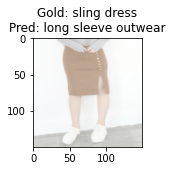

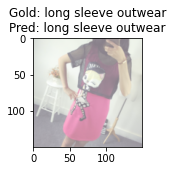

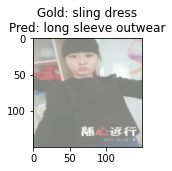

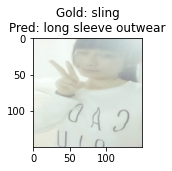

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
outputs = net(images)
predicted = torch.argmax(outputs, 1)
images = images.detach().cpu()
predicted = predicted.detach().cpu()

for img,label,pred in zip(images, labels, predicted):
    img_unnorm = img/2 + 0.5
    img_transp = np.transpose(img_unnorm, (1,2,0))

    fig = plt.figure(figsize=(2,2))
    plt.imshow(img_transp)
    plt.title(f"Gold: {classes[label.item()]}\nPred: {classes[pred.item()]}")

    plt.show()